In [1]:
from socket import gethostname
gethostname()

'DESKTOP-MLCCKJO'

In [2]:
from dotenv import load_dotenv
load_dotenv()

ModuleNotFoundError: No module named 'dotenv'

In [5]:
import os
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [8]:
#establish connection
engine = create_engine(os.getenv('POSTGRE_DB_URL'))


#read the dialogues table into a pandas dataframe
df = pd.read_sql("SELECT * FROM summaries;", engine)
df.head()

,summary_id,dialogue_id,model_id,generated_summary,rouge_1,rouge_2,rouge_l,bert_precision,bert_recall,bert_f1,meteor,memory_summary_usage,time_summary_taken
0,87462,1,mistral 7b,Doctor Hawkins greets Mr. Smith and asks why h...,0.351351,0.159091,0.324324,0.888796,0.906006,0.897319,0.505513,213.601387,0.554711
1,87463,2,mistral 7b,Person1 greets Person2 and checks Ricky's vacc...,0.250000,0.000000,0.218750,0.836484,0.907462,0.870528,0.335816,213.601387,0.554711
2,87464,3,mistral 7b,Person1 lost a set of five keys with a small f...,0.367347,0.074074,0.285714,0.880228,0.880754,0.880491,0.363356,213.601387,0.554711
3,87465,4,mistral 7b,Person1 was upset that Person2 had a girlfrien...,0.233333,0.105263,0.166667,0.868038,0.871339,0.869685,0.304503,213.601387,0.554711
4,87466,5,mistral 7b,Malik approaches Wen and Nikki at the dance fl...,0.392857,0.120482,0.392857,0.869606,0.924768,0.896339,0.529660,213.601387,0.554711


In [9]:
df.describe()

,summary_id,dialogue_id,rouge_1,rouge_2,rouge_l,bert_precision,bert_recall,bert_f1,meteor,memory_summary_usage,time_summary_taken
count,87461.000000,87461.000000,87461.000000,87461.000000,87461.000000,87461.000000,87461.000000,87461.000000,87461.000000,87461.000000,87461.000000
mean,56158.000000,6214.256251,0.265967,0.083105,0.243362,0.872624,0.876832,0.874535,0.293586,412.414413,0.713997
std,25247.960284,3586.928948,0.121877,0.086230,0.115687,0.025675,0.026013,0.022425,0.126054,365.055757,0.307451
min,12428.000000,1.000000,0.000000,0.000000,0.000000,0.679520,0.771940,0.753746,0.000000,72.212168,0.310299
25%,34293.000000,3108.000000,0.177778,0.000000,0.158730,0.855894,0.859863,0.860888,0.201794,185.322930,0.501477
50%,56158.000000,6213.000000,0.262295,0.063830,0.235294,0.872445,0.878384,0.875829,0.286913,251.071660,0.654136
75%,78023.000000,9321.000000,0.342857,0.125000,0.313725,0.888778,0.894161,0.888898,0.373541,757.433262,0.818556
max,99888.000000,12427.000000,1.000000,0.857143,1.000000,0.995707,0.995707,0.995707,0.999314,3583.045781,3.486828


In [10]:
df["model_id"].unique()

array(['mistral 7b', 'falcon 7b', 'deciLM 7b', 'orca2 7b', 'llama 3 8b',
       'gemma 7b', 'zephyr 7b beta'], dtype=object)

In [11]:
df[df["model_id"] == "gemma 7b"].describe()

,summary_id,dialogue_id,rouge_1,rouge_2,rouge_l,bert_precision,bert_recall,bert_f1,meteor,memory_summary_usage,time_summary_taken
count,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000
mean,43967.000000,6214.000000,0.118819,0.005909,0.110966,0.838960,0.846721,0.842705,0.161631,823.424249,0.746005
std,3587.510232,3587.510232,0.052359,0.013656,0.048549,0.014806,0.019478,0.014106,0.088608,56.595262,0.083330
min,37754.000000,1.000000,0.000000,0.000000,0.000000,0.774937,0.781306,0.796645,0.018182,656.576250,0.553492
25%,40860.500000,3107.500000,0.082192,0.000000,0.076923,0.829413,0.833806,0.833101,0.100671,784.726914,0.681030
50%,43967.000000,6214.000000,0.116279,0.000000,0.108108,0.839297,0.845555,0.841897,0.135135,825.625820,0.738925
75%,47073.500000,9320.500000,0.151515,0.000000,0.142857,0.848856,0.858751,0.851118,0.199203,863.859883,0.814531
max,50180.000000,12427.000000,0.468085,0.259259,0.468085,0.897227,0.931543,0.912278,0.669124,1011.066914,1.183100


In [15]:
for m in df["model_id"].unique():
    print(m)
    print(df[df["model_id"] == m]["rouge_1"].median())
    print(df[df["model_id"] == m]["rouge_2"].median())
    print(df[df["model_id"] == m]["rouge_l"].median())
    print(df[df["model_id"] == m]["meteor"].median())
    print(df[df["model_id"] == m]["bert_f1"].median())

mistral 7b
0.2666666624666667
0.0722891522368996
0.2399999964942222
0.3170989551054607
0.8779560923576355
falcon 7b
0.2608695604536862
0.0571428528326533
0.2307692262426036
0.265662859120803
0.8802141547203064
deciLM 7b
0.3448275813555292
0.11538461039201205
0.3157894687396123
0.30256073127973954
0.8864290714263916
orca2 7b
0.31168830693202904
0.09302325200649016
0.2823529363764707
0.32639668767509805
0.8844399452209473
llama 3 8b
0.2857142813161183
0.08450703787343804
0.2608695605965134
0.3326416015625
0.8779307007789612
gemma 7b
0.1162790658491077
0.0
0.1081081037253471
0.1351351351351351
0.8418971300125122
zephyr 7b beta
0.2564102524753452
0.06557376647137891
0.23076922721893492
0.28578166538032757
0.8714001774787903


In [12]:
sdf = pd.read_sql("SELECT dialogue_id, actual_sentiment, model_id, generated_sentiment FROM dialogues NATURAL JOIN sentiments;", engine)
sdf.head()

,dialogue_id,actual_sentiment,model_id,generated_sentiment
0,3816,neutral,mistral 7b,positive
1,3,positive,mistral 7b,positive
2,4,negative,mistral 7b,negative
3,5,positive,mistral 7b,positive
4,6,positive,mistral 7b,positive


In [13]:
sdf["model_id"].unique()

array(['mistral 7b', 'gemma 7b', 'falcon 7b', 'llama 3 8b', 'deciLM 7b',
       'orca2 7b', 'zephyr 7b beta'], dtype=object)

In [14]:
for m in sdf["model_id"].unique():
    print(m)
    print(accuracy_score(sdf[sdf["model_id"] == m]["actual_sentiment"], sdf[sdf["model_id"] == m]["generated_sentiment"]))
    print(f1_score(sdf[sdf["model_id"] == m]["actual_sentiment"], sdf[sdf["model_id"] == m]["generated_sentiment"], average="weighted"))

mistral 7b
0.5912931520077251
0.6069974549911644
gemma 7b
0.5416431962661946
0.5417198367624357
falcon 7b
0.5826828679488211
0.5541661182356187
llama 3 8b
0.5790617204474129
0.5561669853938814
deciLM 7b
0.6130200370161745
0.5713019447562279
orca2 7b
0.6613020037016174
0.6338673673299147
zephyr 7b beta
0.5178240927013761
0.5301164364869373


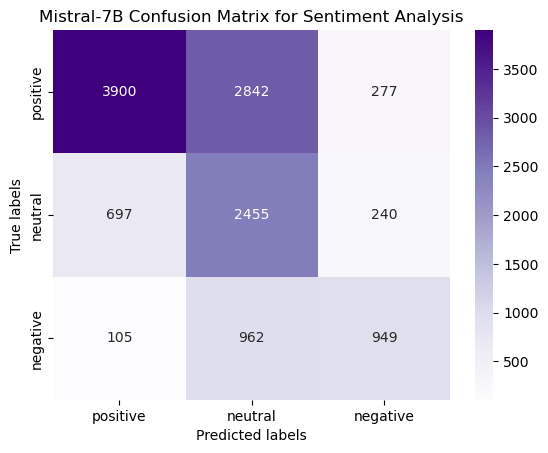

In [ ]:
# Compute the confusion matrix
cm1 = confusion_matrix(sdf[sdf["model_id"] == "mistral 7b"]["actual_sentiment"], sdf[sdf["model_id"] == "mistral 7b"]["generated_sentiment"], labels=['positive', 'neutral', 'negative'])
sns.heatmap(cm1, annot=True, fmt='d', cmap='Purples', xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])


plt.title("Mistral-7B Confusion Matrix for Sentiment Analysis")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

plt.show()

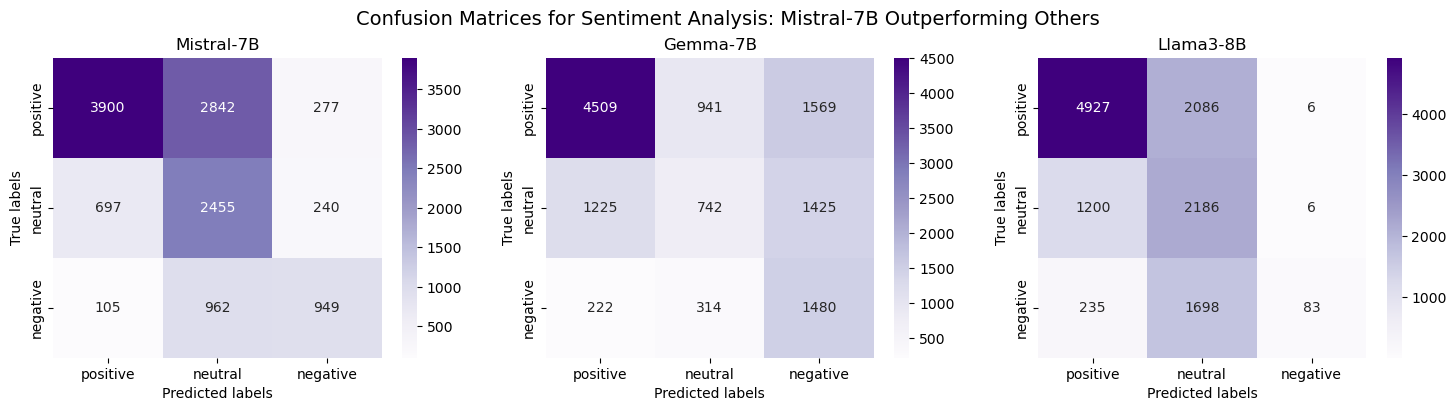

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Compute the confusion matrix
cm1 = confusion_matrix(sdf[sdf["model_id"] == "mistral 7b"]["actual_sentiment"], sdf[sdf["model_id"] == "mistral 7b"]["generated_sentiment"], labels=['positive', 'neutral', 'negative'])
sns.heatmap(cm1, annot=True, fmt='d', cmap='Purples', ax=axes[0], xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
cm2 = confusion_matrix(sdf[sdf["model_id"] == "gemma 7b"]["actual_sentiment"], sdf[sdf["model_id"] == "gemma 7b"]["generated_sentiment"], labels=['positive', 'neutral', 'negative'])
sns.heatmap(cm2, annot=True, fmt='d', cmap='Purples', ax=axes[1], xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
cm3 = confusion_matrix(sdf[sdf["model_id"] == "llama 3 8b"]["actual_sentiment"], sdf[sdf["model_id"] == "llama 3 8b"]["generated_sentiment"], labels=['positive', 'neutral', 'negative'])
sns.heatmap(cm3, annot=True, fmt='d', cmap='Purples', ax=axes[2], xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])

axes[0].set_title('Mistral-7B')
axes[0].set_xlabel('Predicted labels')
axes[0].set_ylabel('True labels')

axes[1].set_title('Gemma-7B')
axes[1].set_xlabel('Predicted labels')
axes[1].set_ylabel('True labels')

axes[2].set_title('Llama3-8B')
axes[2].set_xlabel('Predicted labels')
axes[2].set_ylabel('True labels')

fig.suptitle("Confusion Matrices for Sentiment Analysis: Mistral-7B Outperforming Others", fontsize=14)
# plt.tight_layout(rect=[0, 0.03, 1, 0.93])  # Adjust top margin
plt.subplots_adjust(top=0.86)  # Add this line to make more space for the suptitle

plt.show()

In [ ]:
gemma_scores_df = pd.read_csv("/pub/gaog5/copilot/Datasets/gemma_sample_scores.csv")
gemma_scores_df["model_id"] = "Gemma-7B"
gemma_scores_df.describe()

,dialogue_id,rouge_1,rouge_2,rouge_l,bert_precision,bert_recall,bert_f1,meteor
count,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000
mean,6214.000000,0.118819,0.005909,0.110966,0.838960,0.846721,0.842705,0.161631
std,3587.510232,0.052359,0.013656,0.048549,0.014806,0.019478,0.014106,0.088608
min,1.000000,0.000000,0.000000,0.000000,0.774937,0.781306,0.796645,0.018182
25%,3107.500000,0.082192,0.000000,0.076923,0.829413,0.833806,0.833101,0.100671
50%,6214.000000,0.116279,0.000000,0.108108,0.839297,0.845555,0.841897,0.135135
75%,9320.500000,0.151515,0.000000,0.142857,0.848856,0.858751,0.851118,0.199203
max,12427.000000,0.468085,0.259259,0.468085,0.897227,0.931543,0.912278,0.669124


In [ ]:
cols = ["model_id", "rouge_1", "rouge_2", "meteor", "bert_f1"]

melted_df = df[cols].melt(id_vars='model_id', var_name='metric', value_name='score')
melted_df.head()

,model_id,metric,score
0,mistral 7b,rouge_1,0.351351
1,mistral 7b,rouge_1,0.250000
2,mistral 7b,rouge_1,0.367347
3,mistral 7b,rouge_1,0.233333
4,mistral 7b,rouge_1,0.392857


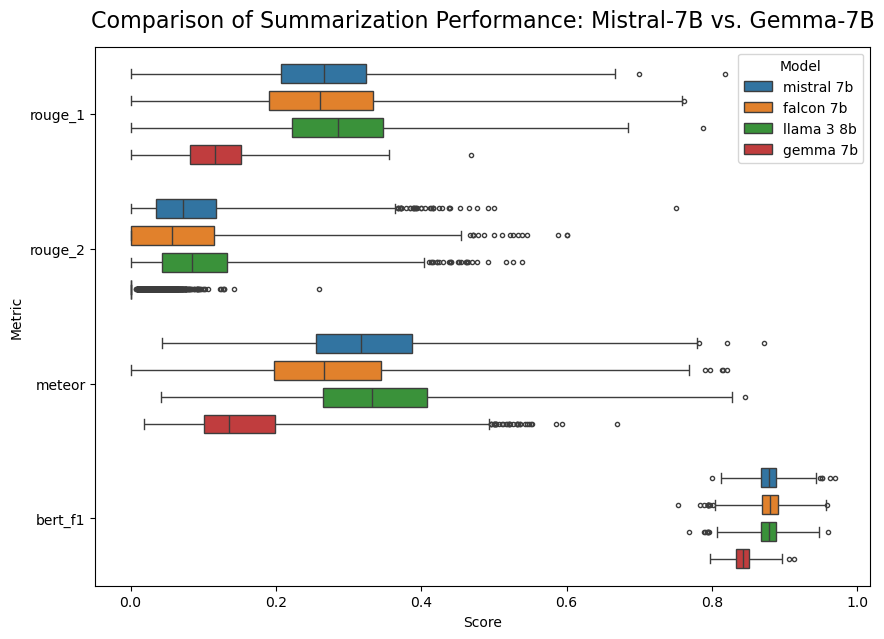

In [ ]:
plt.figure(figsize=(10, 7))
ax = sns.boxplot(x='score', y='metric', hue='model_id', data=melted_df, gap=0.3, fliersize=3, whis=3)
plt.title('Comparison of Summarization Performance: Mistral-7B vs. Gemma-7B', fontsize=16, pad=14)
plt.xlabel('Score')
plt.ylabel('Metric')
plt.legend(title='Model')
# plt.grid(axis='y', linestyle='--', linewidth=0.7)

plt.show()

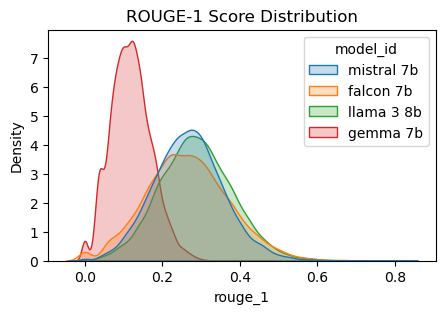

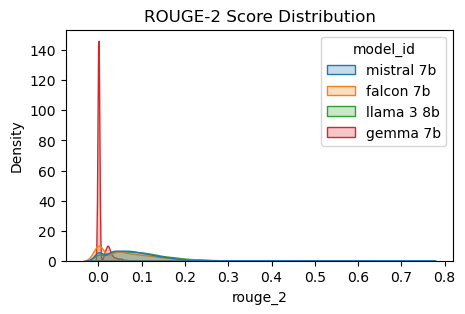

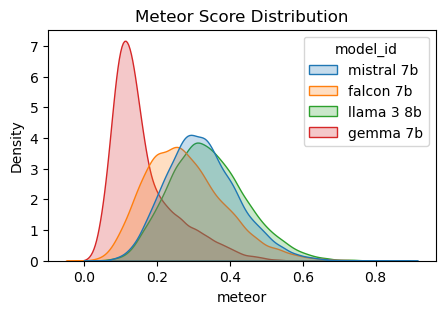

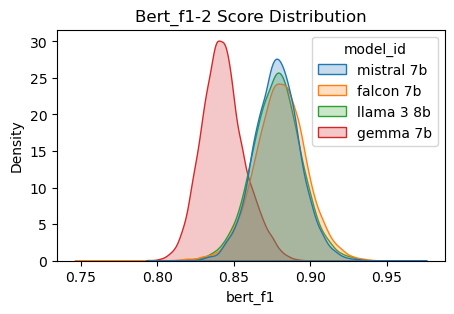

In [ ]:
# Density Plot
plt.figure(figsize=(5, 3))
sns.kdeplot(data=df[cols], x='rouge_1', hue='model_id', fill=True, common_norm=False)
plt.title('ROUGE-1 Score Distribution')
plt.show()

plt.figure(figsize=(5, 3))
sns.kdeplot(data=df[cols], x='rouge_2', hue='model_id', fill=True, common_norm=False)
plt.title('ROUGE-2 Score Distribution')
plt.show()

# Density Plot
plt.figure(figsize=(5, 3))
sns.kdeplot(data=df[cols], x='meteor', hue='model_id', fill=True, common_norm=False)
plt.title('Meteor Score Distribution')
plt.show()

plt.figure(figsize=(5, 3))
sns.kdeplot(data=df[cols], x='bert_f1', hue='model_id', fill=True, common_norm=False)
plt.title('Bert_f1-2 Score Distribution')
plt.show()


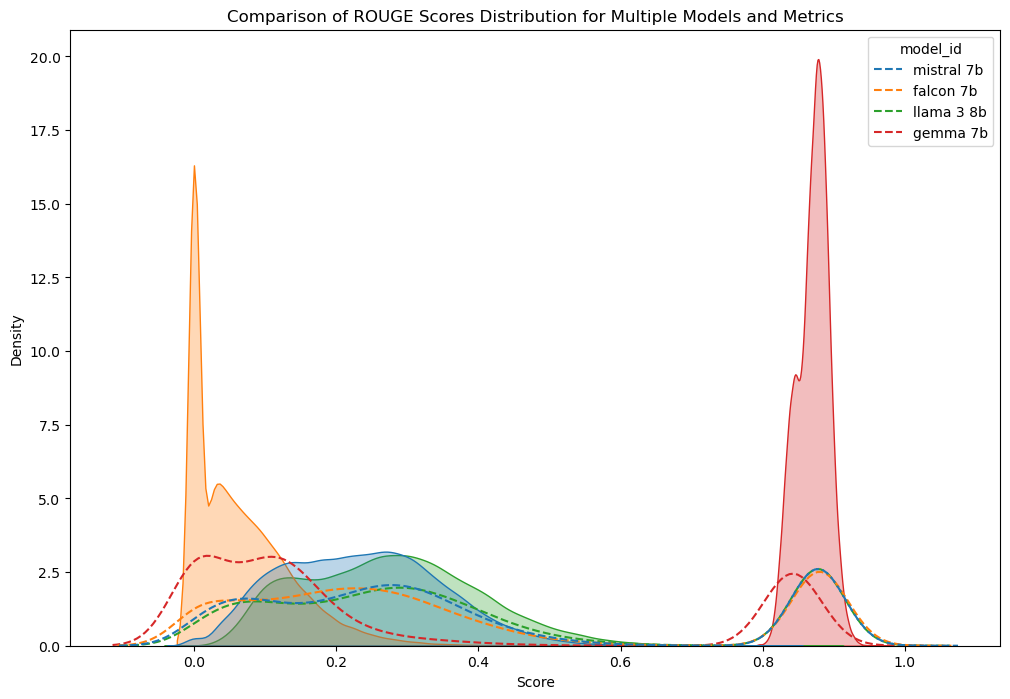

In [ ]:
plt.figure(figsize=(12, 8))
sns.kdeplot(data=melted_df, x='score', hue='metric', fill=True, common_norm=False, palette="tab10", alpha=0.3)
sns.kdeplot(data=melted_df, x='score', hue='model_id', fill=False, common_norm=False, palette="tab10", linestyle="--")
plt.title('Comparison of ROUGE Scores Distribution for Multiple Models and Metrics')
plt.xlabel('Score')
plt.ylabel('Density')
plt.show()

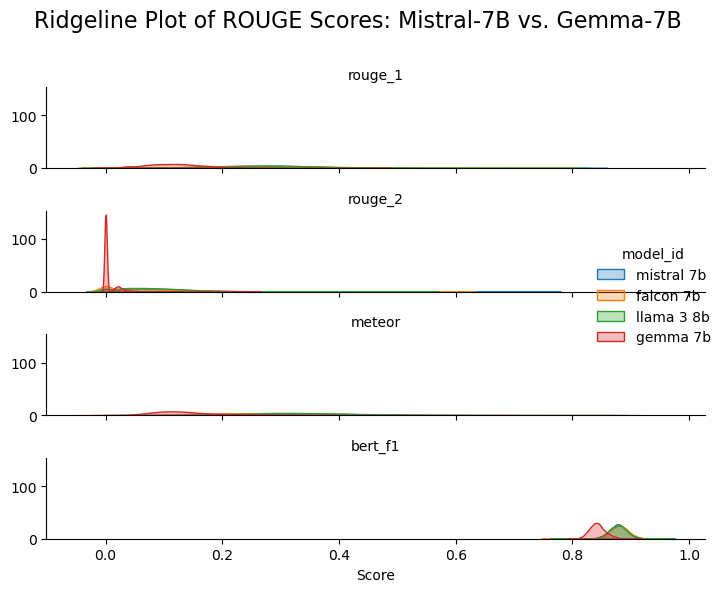

In [ ]:
g = sns.FacetGrid(melted_df, row='metric', hue='model_id', aspect=4, height=1.5)
g.map(sns.kdeplot, 'score', fill=True, alpha=0.3)
g.set_titles(row_template="{row_name}")
g.set_axis_labels("Score", "")
g.figure.suptitle("Ridgeline Plot of ROUGE Scores: Mistral-7B vs. Gemma-7B", fontsize=16)
g.add_legend()
g.figure.tight_layout(rect=[0, 0, 1, 0.97])

plt.show()

In [ ]:
mistral_time_memory_df = pd.read_csv("/pub/gaog5/copilot/Datasets/mistral_summary_results.csv")
gemma_time_memory_df = pd.read_csv("/pub/gaog5/copilot/Datasets/gemma_summary_results.csv")
mistral_time_memory_df.describe()

,dialogue_id,Time Taken (s),GPU Usage (MB)
count,12427.000000,12427.000000,12427.000000
mean,6214.000000,0.644041,236.850986
std,3587.510232,0.082565,19.032949
min,1.000000,0.482282,188.913262
25%,3107.500000,0.587857,224.003184
50%,6214.000000,0.632349,236.717480
75%,9320.500000,0.682641,247.919434
max,12427.000000,0.967282,311.105488


In [ ]:
gemma_time_memory_df.describe()

,dialogue_id,Time Taken (s),GPU Usage (MB)
count,12427.000000,12427.000000,12427.000000
mean,6214.000000,0.746005,823.424249
std,3587.510232,0.083330,56.595262
min,1.000000,0.553492,656.576250
25%,3107.500000,0.681030,784.726914
50%,6214.000000,0.738925,825.625820
75%,9320.500000,0.814531,863.859883
max,12427.000000,1.183100,1011.066914


In [ ]:
llama3_time_memory_df = pd.read_csv("/pub/gaog5/copilot/Datasets/llama3_summary_results.csv")
llama3_time_memory_df.columns = ["dialogue_id", "Summary", "Time Taken (s)", "GPU Usage (MB)"]
llama3_time_memory_df.describe()

,dialogue_id,Time Taken (s),GPU Usage (MB)
count,12427.000000,12427.000000,12427.000000
mean,6214.000000,1.001355,337.338893
std,3587.510232,0.376165,134.385868
min,1.000000,0.755299,231.349043
25%,3107.500000,0.821449,268.121973
50%,6214.000000,0.835025,281.496660
75%,9320.500000,0.866487,300.746582
max,12427.000000,3.432660,1190.739219


In [ ]:
cols = ["Time Taken (s)", "GPU Usage (MB)"]
mistral_time_memory_df = mistral_time_memory_df[cols]
mistral_time_memory_df["Model"] = "Mistral-7B"

gemma_time_memory_df = gemma_time_memory_df[cols]
gemma_time_memory_df["Model"] = "Gemma-7B"

llama3_time_memory_df = llama3_time_memory_df[cols]
llama3_time_memory_df["Model"] = "Llama3-8B"

time_memory_df_combined = pd.concat([mistral_time_memory_df, gemma_time_memory_df, llama3_time_memory_df], ignore_index=True)

time_memory_df_combined

,Time Taken (s),GPU Usage (MB),Model
0,0.554711,213.601387,Mistral-7B
1,0.554711,213.601387,Mistral-7B
2,0.554711,213.601387,Mistral-7B
3,0.554711,213.601387,Mistral-7B
4,0.554711,213.601387,Mistral-7B
...,...,...,...
37276,1.690911,572.917734,Llama3-8B
37277,0.830272,277.273711,Llama3-8B
37278,0.877787,310.952031,Llama3-8B
37279,0.830272,277.273711,Llama3-8B


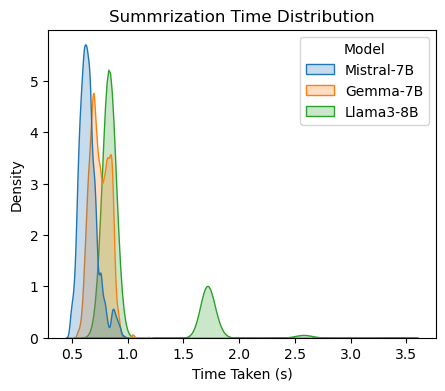

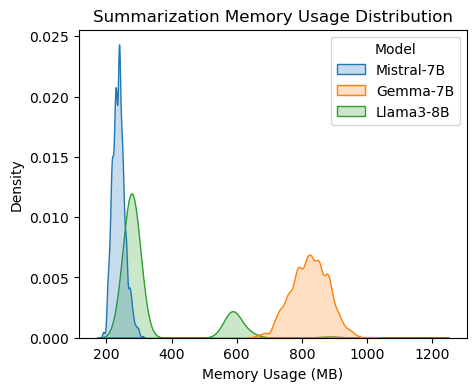

In [ ]:
plt.figure(figsize=(5, 4))
sns.kdeplot(data=time_memory_df_combined, x='Time Taken (s)', hue='Model', fill=True, common_norm=False)
plt.title('Summrization Time Distribution')
plt.show()

plt.figure(figsize=(5, 4))
sns.kdeplot(data=time_memory_df_combined, x='GPU Usage (MB)', hue='Model', fill=True, common_norm=False)
plt.title('Summarization Memory Usage Distribution')
plt.xlabel("Memory Usage (MB)")
plt.show()

In [18]:
df_o = pd.read_sql("SELECT * FROM dialogues;", engine)
df_o

,dialogue_id,dataset,dialogue_text,actual_summary,actual_sentiment
0,3816,training,"#Person1#: Good morning, sir. Is there anythin...",#Person2# wants a suit made in 100 % black Bar...,neutral
1,3,training,"#Person1#: Excuse me, did you see a set of key...",#Person1#'s looking for a set of keys and asks...,positive
2,4,training,#Person1#: Why didn't you tell me you had a gi...,#Person1#'s angry because #Person2# didn't tel...,negative
3,5,training,"#Person1#: Watsup, ladies! Y'll looking'fine t...",Malik invites Nikki to dance. Nikki agrees if ...,positive
4,6,training,"#Person1#: Happy birthday, Aims!\n#Person2#: T...",Lisa gives Aims a birthday present and Aims lo...,positive
...,...,...,...,...,...
12422,11324,training,"#Person1#: Come on, we're going to be late for...",#Person2#'s reading a business magazine and te...,neutral
12423,11329,training,"#Person1#: Sir, may I please see your license ...",#Person2# was caught by #Person1# for speeding...,positive
12424,11333,training,#Person1#: I don't know what to say. This can'...,#Person1# and #Person2# are surprised at Taylo...,negative
12425,11336,training,#Person1#: How do you get along with your co-w...,#Person2# complains about a co-worker's gossip...,negative


In [21]:
df_o[df_o["dialogue_id"] == 3]

,dialogue_id,dataset,dialogue_text,actual_summary,actual_sentiment
1,3,training,"#Person1#: Excuse me, did you see a set of key...",#Person1#'s looking for a set of keys and asks...,positive
